In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

import joblib


In [2]:
# Load train.csv from your data folder
df = pd.read_csv("../data/train.csv")

# Quick view
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


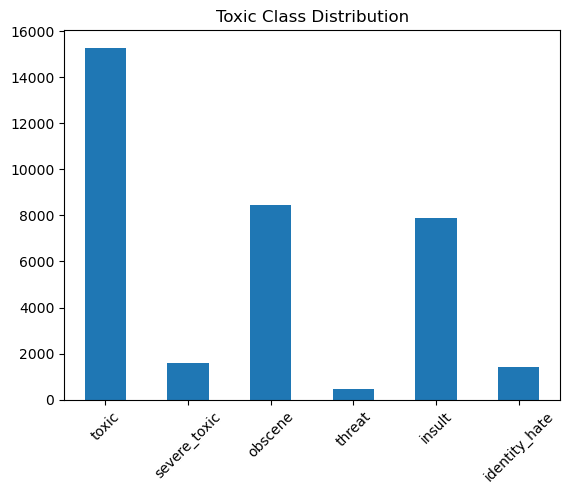

In [3]:
# Check for nulls
df.isnull().sum()

# Class distribution
df.iloc[:, 2:].sum().plot(kind='bar', title="Toxic Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [4]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df["clean_comment"] = df["comment_text"].apply(clean_text)


In [5]:
X = df["clean_comment"]
y = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [6]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [7]:
models = {}
for label in y.columns:
    print(f"Training model for: {label}")
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_tfidf, y_train[label])
    preds = model.predict(X_test_tfidf)
    
    print(f"Classification Report for {label}")
    print(classification_report(y_test[label], preds))
    
    models[label] = model


Training model for: toxic
Classification Report for toxic
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28859
           1       0.90      0.61      0.73      3056

    accuracy                           0.96     31915
   macro avg       0.93      0.80      0.85     31915
weighted avg       0.95      0.96      0.95     31915

Training model for: severe_toxic
Classification Report for severe_toxic
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     31594
           1       0.59      0.21      0.31       321

    accuracy                           0.99     31915
   macro avg       0.79      0.61      0.65     31915
weighted avg       0.99      0.99      0.99     31915

Training model for: obscene
Classification Report for obscene
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     30200
           1       0.92      0.60      0.72  

In [8]:
joblib.dump(models, "../models/logistic_models.pkl")
joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")

['../models/tfidf_vectorizer.pkl']

In [9]:
import numpy as np

logreg_probs = np.column_stack([
    model.predict_proba(X_test_tfidf)[:, 1] for model in models.values()
])

np.save("../outputs/logreg_probs.npy", logreg_probs)